In [44]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from tabulate import tabulate
import swifter
from tqdm import tqdm

from packages.preprocessing import preprocess_text

In [2]:
path = os.getcwd()
path_data = os.path.join(path, 'data')

In [105]:
df = pd.read_csv(path_data + '/financial_phrasebank_sentences_75agree.csv')

In [106]:
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|    | sentence                                                                                                                                                                                                       |   label |
|----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------|
|  0 | According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .                                                                                |       1 |
|  1 | With the new production plant the company would increase its capacity to meet the expecte

# **Part 0: Dataset Selection**

- Objective: Financial Phrasebank - HuggingFace hub.
- This dataset includes sentences from financial news.
  
# **Part 1: Setting Up the Problem** (1.5 points)

- **Objective**: Understand and establish the baseline for your chosen dataset.


### a. Bibliography and SOA (0.25 points):
  -  **Main Objective**: The task is a **multiclass sentiment classification** problem in the financial domain. Given a sentence from a financial news article, the model must classify it as:
     - 0 → Negative
     - 1 → Neutral
     - 2 → Positive
  -  **Business Application**: Financial sentiment analysis aids automated trading, risk alert systems, investment strategies, and the prevention of significant losses.
  
  -  **Benchmark**: RF?

### b. Dataset Description (0.5 points):

Provide a brief overview of your dataset, including size, class distribution, and any peculiar characteristics. Include basic descriptive statistics.

**Preprocessing**

In this step, we are applying the following preprocessing pipeline to each sentence in the dataset:

1. **Lowercasing** → Converts all characters to lowercase for uniformity.
2. **Digit and Punctuation Removal** → Removes numbers, punctuation, and extra spaces using regular expressions.
3. **Tokenization** → Splits sentences into individual words using NLTK's `word_tokenize`.
4. **Stopword Removal** → Filters out common English stopwords using NLTK's predefined list. Only tokens with 3 or more characters are kept.
5. **POS Tagging & Lemmatization** → Performs part-of-speech tagging and then lemmatizes tokens using NLTK's `WordNetLemmatizer`, which helps group different forms of a word together (e.g., “increased” → “increase”).

**Note:** This preprocessing pipeline is designed for exploratory analysis and rule-based models. It should **not** be used prior to Transformer models like BERT, which require raw text and their own tokenizer.

In [8]:
df = preprocess_text(df, col='sentence')

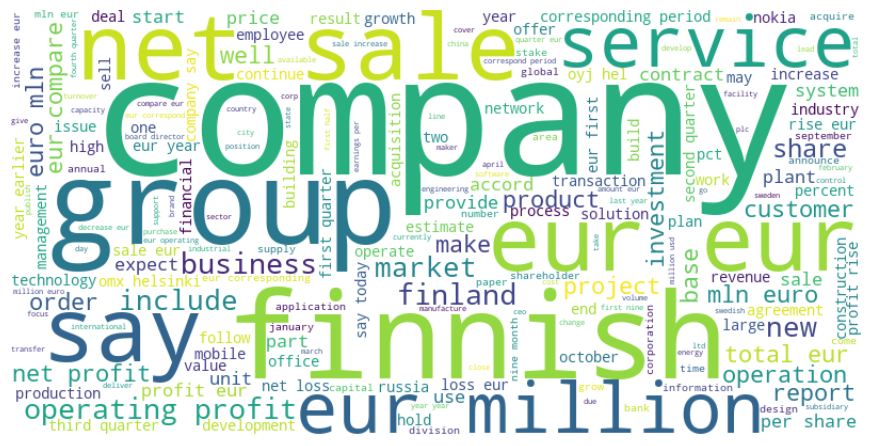

In [ ]:
# This helps to quickly identify the dominant terms and themes present in the dataset after cleaning.
text = ' '.join(df['clean_sentence'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(11, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

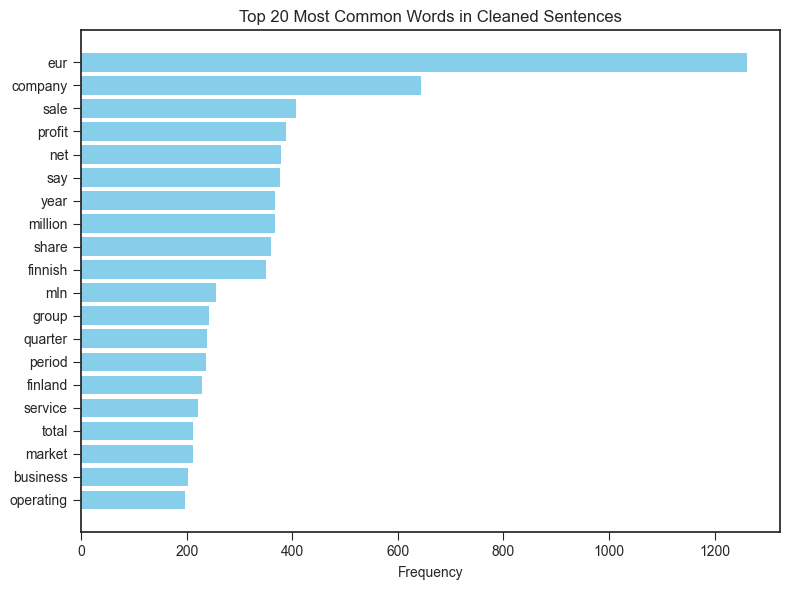

In [92]:
# Count the most common words in 'clean_sentence'
all_words = ' '.join(df['clean_sentence']).split()
word_counts = Counter(all_words)
most_common = word_counts.most_common(20)

words, counts = zip(*most_common)

plt.style.use('seaborn-v0_8-ticks')
plt.figure(figsize=(8, 6))
plt.barh(words[::-1], counts[::-1], color='skyblue')
plt.xlabel('Frequency', fontsize=10, labelpad=5)
plt.title('Top 20 Most Common Words in Cleaned Sentences', fontsize=12)
plt.tight_layout()
plt.show()

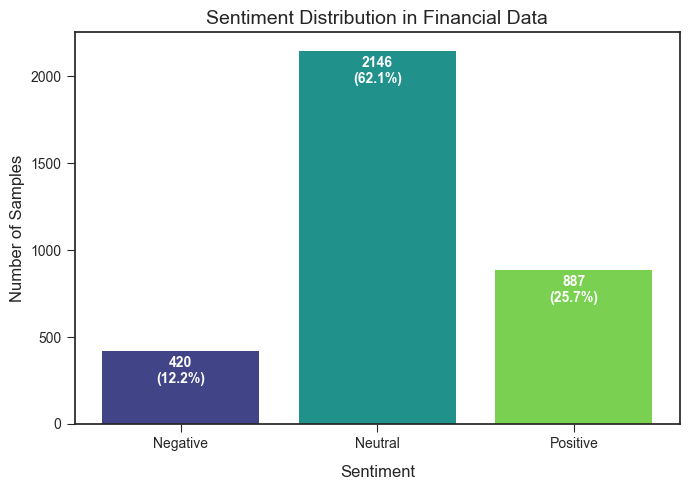

In [58]:
# In the next plot we can see the distribution for our target!
class_counts = df['label'].value_counts().sort_index()
class_percent = df['label'].value_counts(normalize=True).sort_index() * 100

labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(class_counts)))

# Plot configuration
plt.style.use('seaborn-v0_8-ticks')
plt.figure(figsize=(7, 5))
bars = plt.bar(class_counts.index, class_counts, color=colors)

plt.xticks([0, 1, 2], ["Negative", "Neutral", "Positive"], fontsize=10)
plt.xlabel('Sentiment', fontsize=12, labelpad=10)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Sentiment Distribution in Financial Data', fontsize=14)

# Annotate bars with counts and percentages, adjusting position
for bar, count, percent in zip(bars, class_counts, class_percent):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 30, 
            f"{count}\n({percent:.1f}%)", ha='center', va='top', 
            fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

In [86]:
# Key Statistics for Sentence Length by Label
df['sentence_length'] = df['sentence'].apply(lambda x: len(word_tokenize(x)))

stats = df.groupby('label')['sentence_length'].agg(['mean', 'min', 'max', 'std', 'median', 'count']).rename(index=labels)
print(tabulate(stats, headers='keys', tablefmt='psql'))

+----------+---------+-------+-------+----------+----------+---------+
| label    |    mean |   min |   max |      std |   median |   count |
|----------+---------+-------+-------+----------+----------+---------|
| Negative | 24.5167 |     5 |    56 | 10.1632  |       22 |     420 |
| Neutral  | 21.6034 |     2 |    81 |  9.82973 |       20 |    2146 |
| Positive | 24.9064 |     6 |    57 | 10.3279  |       23 |     887 |
+----------+---------+-------+-------+----------+----------+---------+


### c. Random Classifier Performance (0.25 points):
Calculate the expected performance of a random classifier for your dataset to set a benchmark. The calculation should include an  implementation.

**Expected accuracy** of two types of random classifiers:
1. A **weighted random classifier**, which predicts labels according to their empirical distribution.
2. A **uniform random classifier**, which assigns equal probability to all labels.

In [83]:
# First, calculate the empirical distribution of the labels
label_counts = df['label'].value_counts(normalize=True).sort_index()
label_probs = label_counts.values

# --- Weighted Random Classifier ---
expected_accuracy_weighted = np.sum(label_probs ** 2)
print(f"Expected accuracy (Weighted Random Classifier): {expected_accuracy_weighted * 100:.2f}%")

# --- Uniform Random Classifier ---
n_classes = len(label_probs)
expected_accuracy_uniform = 1 / n_classes
print(f"Expected accuracy (Uniform Random Classifier): {expected_accuracy_uniform * 100:.2f}%")

Expected accuracy (Weighted Random Classifier): 46.70%
Expected accuracy (Uniform Random Classifier): 33.33%


### d. Baseline Implementation (0.5 points): 
Develop a rule-based classifier as a baseline. Discuss its performance in the context of the dataset's complexity and compare it with human-level performance if available.

**Rule-based classifier** using keyword matching to serve as a baseline. The classifier assigns labels based on the presence of key terms frequently appearing in each class:

- Class 2 (Financial Results): keywords like profit, loss, revenue, quarter, net
- Class 1 (Forward-looking/Event): keywords like expect, plan, contract, project, forecast
- Class 0: default when no keywords match

In [103]:
def rule_based_classifier(text):
    financial_keywords = [
        'profit', 'loss', 'revenue', 'result', 'sale', 'income', 'operating', 'quarter', 'net',
        'mln', 'million', 'billion', 'growth', 'earnings', 'report', 'decrease',
        'increase', 'rise', 'compare', 'estimate', 'value', 'financial']
    forward_keywords = [
        'expect', 'plan', 'will', 'forecast', 'agreement', 'contract', 'project', 'develop',
        'build', 'acquisition', 'start', 'construction', 'deal', 'estimate', 'future', 'provide']

    text = text.lower()
    if any(word in text for word in financial_keywords):
        return 2
    elif any(word in text for word in forward_keywords):
        return 1
    else:
        return 0

df['rule_pred'] = df['clean_sentence'].apply(rule_based_classifier)

# Evaluate performance
from sklearn.metrics import classification_report
print(classification_report(df['label'], df['rule_pred'], digits=3))


              precision    recall  f1-score   support

           0      0.057     0.171     0.086       420
           1      0.761     0.223     0.345      2146
           2      0.374     0.660     0.478       887

    accuracy                          0.329      3453
   macro avg      0.397     0.351     0.303      3453
weighted avg      0.576     0.329     0.347      3453

